Statisiques descriptives sur les tmpératures relevés et predites en France métropolitaine sur l'année 2023

In [1]:
#importaiton des modules necessaires

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

Préparations des fichiers : 

In [2]:
#ouverture des fichiers pour l'instant pas toutes les communes car très long à obtenir mais un jour peut-être !
communes_de_france_part1_predicted = pd.read_csv('france_communes_hourly_past_predicted_temperature_2m_2023_partie1.csv')
communes_de_france_part1_real = pd.read_csv('france_communes_hourly_past_real_temperature_2m_2023_partie1.csv')

In [5]:
#on renomme la colonne température du fichier des relevés pour distinguer températures réelles des températures prédites 
communes_de_france_part1_real = communes_de_france_part1_real.rename(columns={'temperature_2m': 'temperature_relle_2m'})

In [ ]:
# on joint les deux fichier pour pouvoir comparer au sein d'une mêm table les températures à une même date et un même lieu
merged_df = pd.merge(communes_de_france_part1_real,communes_de_france_part1_predicted, on=['date', 'longitude', 'latitude'])
print(len(merged_df))
print(merged_df)

In [ ]:
#ajout des colonnes erreur et erreur absolue. Cette dernière est importante car le modèle se trompe presque autant en positif qu'en négatif, ainsi la moyenne de l'erreur est presque nuelle, ce qui ne nous renseigne pas beaucoup 

merged_df["error"]=merged_df["temperature_2m"]-merged_df["temperature_relle_2m"]
merged_df["absolute_error"]=abs(merged_df["error"])

In [55]:
merged_df.describe()

,Unnamed: 0_x,temperature_relle_2m,latitude,longitude,Unnamed: 0_y,temperature_2m,error,absolute_error
count,2.182622e+07,2.182622e+07,2.182622e+07,2.182622e+07,2.182622e+07,2.182622e+07,2.182622e+07,2.182622e+07
mean,4.377007e+03,1.168604e+01,4.693262e+01,4.609368e+00,4.377007e+03,1.170925e+01,2.320762e-02,1.150681e+00
std,2.527363e+03,7.994910e+00,2.164371e+00,1.279891e+00,2.527363e+03,8.046429e+00,1.592198e+00,1.100711e+00
min,0.000000e+00,-2.723350e+01,4.358747e+01,2.305686e+00,0.000000e+00,-2.445350e+01,-1.622250e+01,0.000000e+00
25%,2.188000e+03,6.046000e+00,4.481662e+01,3.450723e+00,2.188000e+03,5.956500e+00,-7.875000e-01,3.790010e-01
50%,4.377000e+03,1.119950e+01,4.627315e+01,4.131340e+00,4.377000e+03,1.109800e+01,8.299990e-02,8.389980e-01
75%,6.566000e+03,1.742200e+01,4.936749e+01,5.770176e+00,6.566000e+03,1.727250e+01,8.805000e-01,1.575000e+00
max,8.759000e+03,4.214650e+01,5.004822e+01,7.422222e+00,8.759000e+03,4.208900e+01,1.658700e+01,1.658700e+01


Ainsi on remarque que l'erreur de prediction de température est proche de 0 mais lorsque l'on prend l'écart de température absolue, on obtien une erreur moyenne de 1.15°, l'erreur absolue maximale de prévision fut en 2023 de 16.5° ! 

Etude par localisation des écarts de températures 

restriction à une seule heure de la journée et à une seule date. prenons le 1 er setptembre 2023 à 8h du matin 


In [39]:
merged_df['date'] = pd.to_datetime(merged_df['date']) # pour pouvoir facilement selectionner la date 

In [ ]:
une_seule_date = merged_df[merged_df["date"].dt.month == 9]
une_seule_date =  une_seule_date[une_seule_date["date"].dt.day == 1]
une_seule_date =  une_seule_date[une_seule_date["date"].dt.hour == 8]

print(len(une_seule_date))

2493


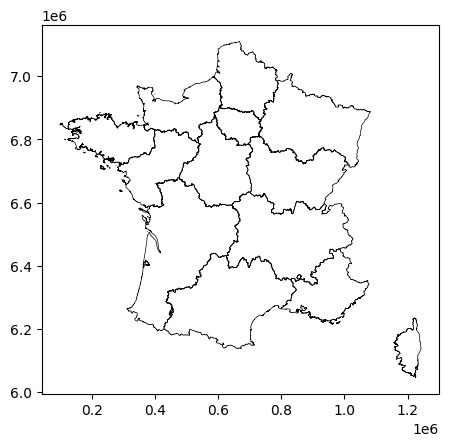

In [41]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]
france_2154 = france.to_crs(2154)
ax1 = france_2154.boundary.plot(edgecolor="k", linewidth=0.5)


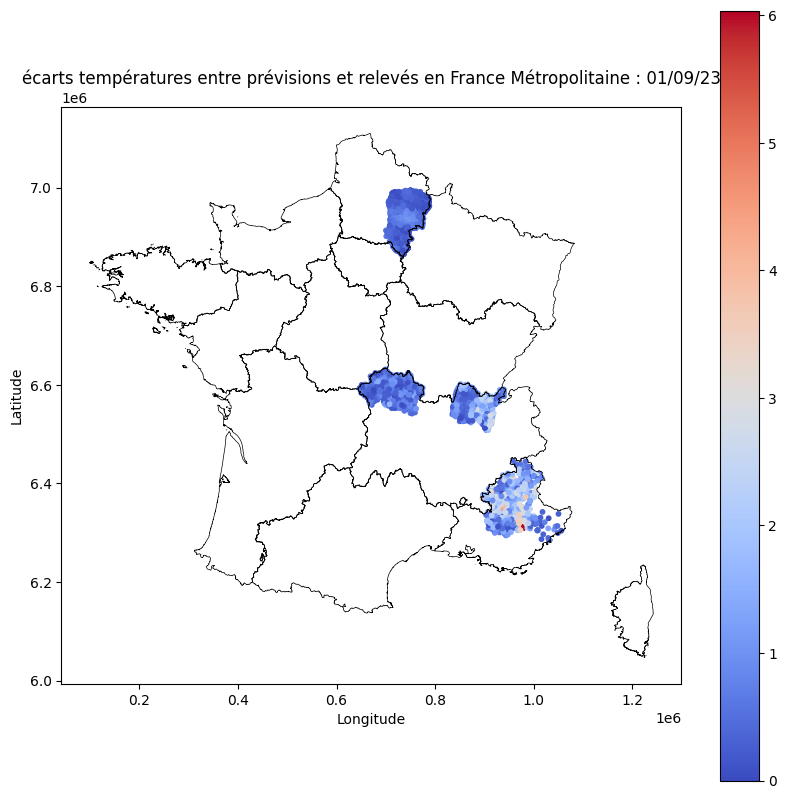

In [53]:
# Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326
geometry = [Point(xy) for xy in zip(une_seule_date["longitude"], une_seule_date["latitude"])]
geo_result = gpd.GeoDataFrame(une_seule_date, geometry=geometry, crs="EPSG:4326")

# Reprojections de vos points en Lambert-93 (pour correspondre à france_2154)
geo_result_2154 = geo_result.to_crs(2154)

# Afficher la carte avec la France et les températures sur celle-ci
fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les frontières de la France métropolitaine
france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

# Afficher les points de température sur la carte
# Utiliser une couleur pour représenter la température
geo_result_2154.plot(ax=ax, column="absolute_error", cmap="coolwarm", markersize=10, legend=True)

# Afficher la carte avec les légendes
plt.title("écarts températures entre prévisions et relevés en France Métropolitaine : 01/09/23")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Etude des écarts entre relevés et prévision sur un lieu particulier au cours de l'année 2023 : on prend la première commune de la liste : 

In [56]:
un_seul_lieu = merged_df.head(8755)
une_seul_lieu_une_heure = un_seul_lieu[un_seul_lieu["date"].dt.hour == 8]


Text(0.5, 1.0, 'série temporelle des prévisions et relevés de température sur 1 an à une localisation donnée')

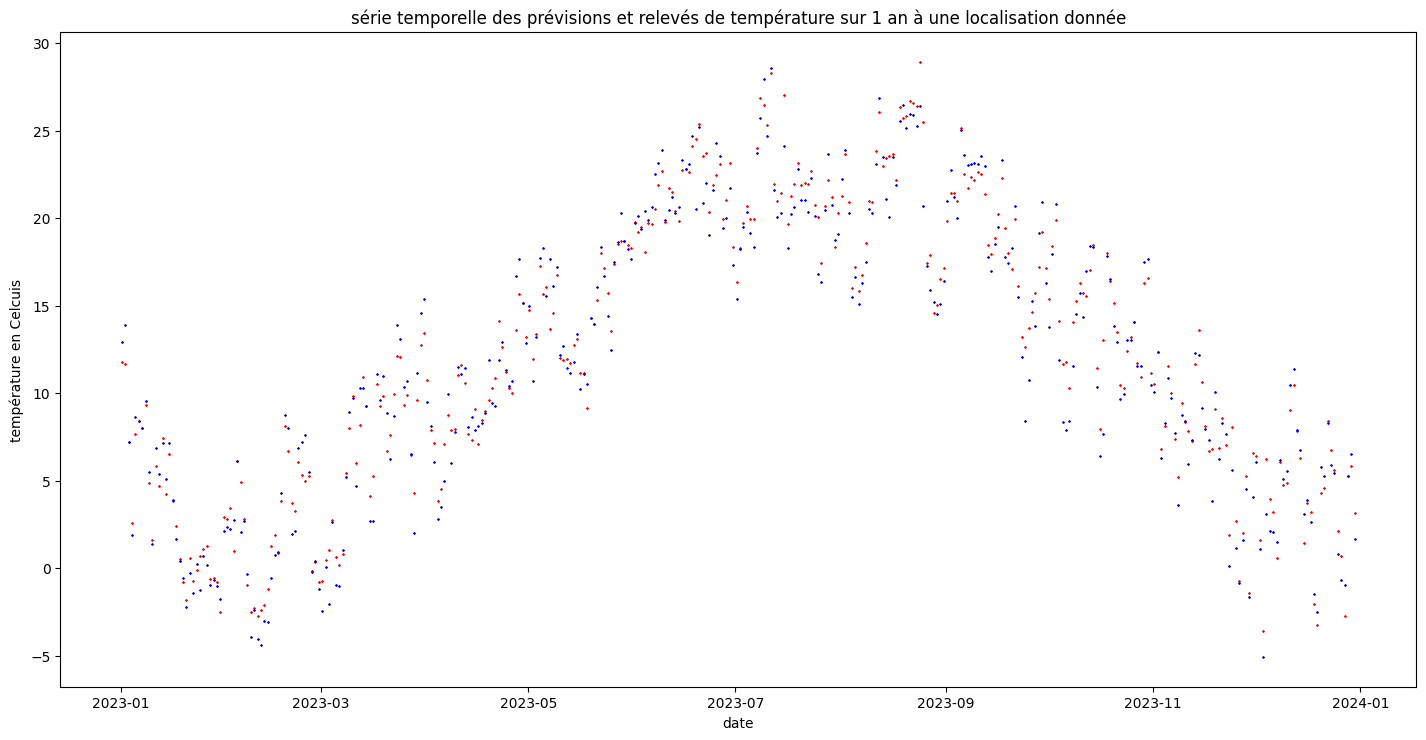

In [57]:
x = une_seul_lieu_une_heure["date"]
y1 = une_seul_lieu_une_heure["temperature_relle_2m"]
y2 = une_seul_lieu_une_heure["temperature_2m"]

fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=0.5) # température réelle 
plt.scatter(x, y2, c='b', marker='X', s=0.5)  # température prédite par le modèle 

# Set labels
plt.xlabel('date')
plt.ylabel('température en Celcuis')
plt.title("série temporelle des prévisions et relevés de température sur 1 an à une localisation donnée")


ajout lign ede texte 